# MuJoCO多参数并行实验
水平弹簧f1 100 刚度 771\
倾斜弹簧f2 290 刚度 2000\
连接球弹簧f3 计算 67000\
内部初始角速度 1000degree/s = 57.295779513 rad/s\
减速时扭矩 100Nm


| 测试 | 参数 | 范围       | 组数 |
|------|------|------------|------|
| 1    | z    | [0, 165]   | 240  |
| 2    | f1   | [20, 200]  | 240  |
| 3    | f2   | [150, 400] | 240  |


In [2]:
# 导入相关库
import re
import ast
import os
import sys
from time import time, sleep
import xml.etree.ElementTree as ET

import pandas as pd
import pickle
import numpy as np
import keyboard
import matplotlib.pyplot as plt

import mujoco.viewer as mj_viewer
import mujoco as mj

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)

from xlsxConverter import XLSXConverter
import tt12_with_middle as tt_csv

import tt12_control_0911 as tt_ctrl

def reload_module(module_name, alias=None):  
    import importlib  
    module = importlib.import_module(module_name)  
    importlib.reload(module)  

    globals()[alias] = module  # 将模块赋值给全局变量  
    return module

In [3]:
# 定义常量
z_list = np.linspace(0, 165, 240)
f1_list = np.linspace(20, 200, 240)
f2_list = np.linspace(150, 400, 240)
xlsx_path = '../data/xlsx/topology_TSR_flexible_strut_ball_foot_v1_R.xlsx'


In [150]:
np.sqrt(175**2+165**2)*0.001

0.24052026941611387

In [154]:
def cal_ori_length(z=165, f1=100, f2=290, length1=0.35, length2=0.35/2*np.sqrt(2), length3=np.sqrt(175**2+165**2)*0.001):
    a=350/2
    f3 = (f2/np.sqrt(2) - f1)*2*np.sqrt(a**2+z**2)/(a-z)
    # print(f3)
    stiffness1 = 771  # N/m    
    stiffness2 = 2000
    stiffness3 = 67000

    dx1 = f1/stiffness1
    dx2 = f2/stiffness2
    dx3 = f3/stiffness3
    ori_length1 = abs(dx1-length1)
    ori_length2 = abs(dx2-length2)
    ori_length3 = abs(dx3-length3)
    return ori_length1, ori_length2, ori_length3

def cal_experiment_param_4(z=165, a=175):
    return (a+z)*2*0.001
cal_ori_length()
# 

5053.858395660793


(0.22029831387808038, 0.10248737341529165, 0.16508954709281848)

In [162]:
reload_module('tt12_control_0911', 'tt_ctrl')
reload_module('tt12_with_middle', 'tt_csv')

<module 'tt12_with_middle' from 'd:\\document\\desktop\\program\\TGMJ2\\tests\\..\\src\\tt12_with_middle.py'>

5053.858395660793
ori_length_3: 0.16508954709281848


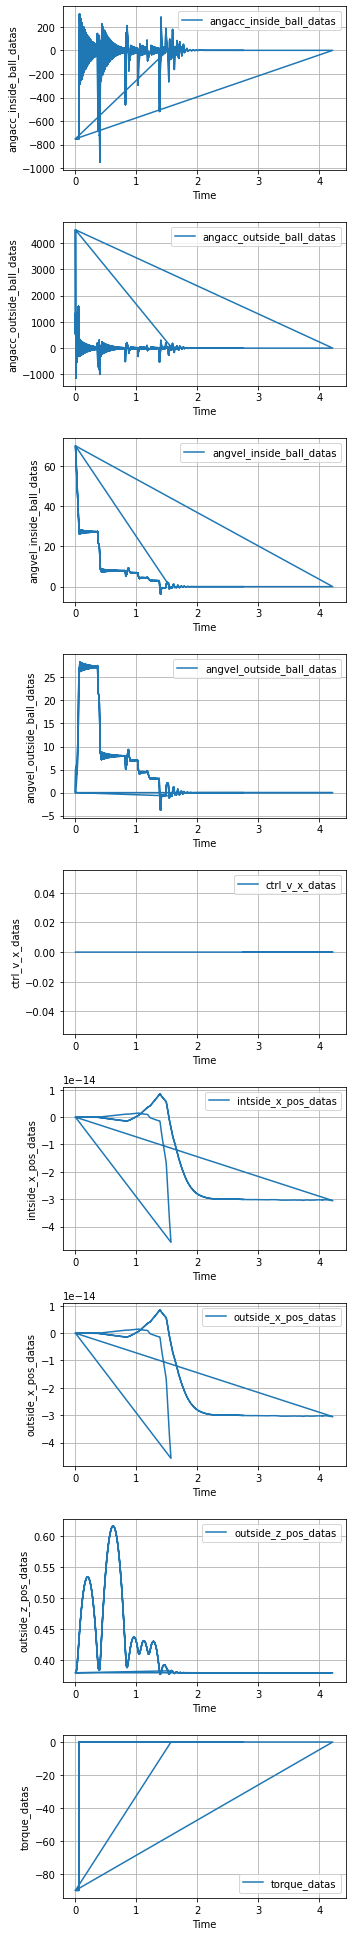

In [169]:
import mujoco as mj
import os
import sys

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)

from xlsxConverter import XLSXConverter
import tt12_with_middle as tt_csv

import tt12_control_0911 as tt_ctrl

def reload_module(module_name, alias=None):  
    import importlib  
    module = importlib.import_module(module_name)  
    importlib.reload(module)  

    globals()[alias] = module  # 将模块赋值给全局变量  
    return module

reload_module('tt12_control_0911', 'tt_ctrl')
reload_module('tt12_with_middle', 'tt_csv')

index = 1
xlsx_path = '../data/xlsx/topology_TSR_flexible_strut_ball_foot_v1_R.xlsx'
csv_path = f'../data/csv/data_tt12bar_0912_{index}.csv'  
export_xml_file_path = '../data/xml/'  
# export_xml_file_name = f"TT12_0912_{index}.xml"  
export_xml_file_name = f"TT12_0912.xml"  
xml_path = os.path.join(export_xml_file_path, export_xml_file_name)

# 创建 TT12WithMiddle 实例并处理数据  
tt12 = tt_csv.TT12WithMiddle(xlsx_path, displacement=(0, 0, 0.38))  
# tt12 = tt_csv.TT12WithMiddle(xlsx_path, displacement=(0, 0, 1))  
ori_length_1, ori_length_2, ori_length_3 = cal_ori_length()
print('ori_length_3:', ori_length_3)
tt12.fill_all_data(ori_length_1=ori_length_1, ori_length_2=ori_length_2, ori_length_3=ori_length_3)
tt12.export_to_csv(csv_path)  

# 创建 TT12_MJCF 实例并生成模型  
tt12_mjcf = tt_ctrl.TT12_MJCF()  
tt12_mjcf.time_step = 0.00001  
# tt12_mjcf.gravity = (0, 0, 0)  
tt12_mjcf.tongue = -90
tt12_mjcf.generate_tt_model(csv_path, tt_model_name='tt_model_0', pos=(0, 0, 0))  
tt12_mjcf.export_to_xml_file(export_xml_file_path, export_xml_file_name)
# 创建 TT12_Control 实例并进行仿真  

tt12_control = tt_ctrl.TT12_Control(xml_path, keyframe_id=0)  
tt12_control.Hz = 2000  
tt12_control.is_control = True  
tt12_control.simulate(is_render=True, stop_time=5)
tt12_control.recorded_data.plot_all_data()
# tt12_control.recorded_data.save_data(save_data_csv)

In [172]:
z_list = np.linspace(0.01, 0.1, 10)
f1_list = np.linspace(0.01, 0.1, 10)
f2_list = np.linspace(0.01, 0.1, 10)
all_list = [z_list, f1_list, f2_list]
folder_name_list = ['0913_z', '0913_f1', '0913_f2', '0913_initial_velocity', '0913_floor_torsional_friction', '0913_floor_rolling_friction']
i = 1
[(value, j, folder_name_list[i]) for j, value in enumerate(all_list[i])]

[(0.01, 0, '0913_f1'),
 (0.020000000000000004, 1, '0913_f1'),
 (0.030000000000000006, 2, '0913_f1'),
 (0.04000000000000001, 3, '0913_f1'),
 (0.05000000000000001, 4, '0913_f1'),
 (0.06000000000000001, 5, '0913_f1'),
 (0.07, 6, '0913_f1'),
 (0.08, 7, '0913_f1'),
 (0.09000000000000001, 8, '0913_f1'),
 (0.1, 9, '0913_f1')]

In [135]:
0.0271/24

0.0011291666666666666

In [138]:
np.linspace(-200, -10, 100)

array([-200.        , -198.08080808, -196.16161616, -194.24242424,
       -192.32323232, -190.4040404 , -188.48484848, -186.56565657,
       -184.64646465, -182.72727273, -180.80808081, -178.88888889,
       -176.96969697, -175.05050505, -173.13131313, -171.21212121,
       -169.29292929, -167.37373737, -165.45454545, -163.53535354,
       -161.61616162, -159.6969697 , -157.77777778, -155.85858586,
       -153.93939394, -152.02020202, -150.1010101 , -148.18181818,
       -146.26262626, -144.34343434, -142.42424242, -140.50505051,
       -138.58585859, -136.66666667, -134.74747475, -132.82828283,
       -130.90909091, -128.98989899, -127.07070707, -125.15151515,
       -123.23232323, -121.31313131, -119.39393939, -117.47474747,
       -115.55555556, -113.63636364, -111.71717172, -109.7979798 ,
       -107.87878788, -105.95959596, -104.04040404, -102.12121212,
       -100.2020202 ,  -98.28282828,  -96.36363636,  -94.44444444,
        -92.52525253,  -90.60606061,  -88.68686869,  -86.76767

In [4]:
# 将a的每一个元素乘以0.001
a = [1, 2, 3, 4, 5]
a = [i * 0.001 for i in a]
len(a)

5

In [6]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [12]:
250*16/36

111.11111111111111

In [13]:
# 蒙牛
250*24/56

107.14285714285714

In [14]:
200*24/58

82.75862068965517

In [15]:
205*16/50

65.6

In [17]:
a = [1, 2, 3, 4, 5]
b = [6, 7, 8, 9, 10]
# 算a-b的差值
diff = [a[i] - b[i] for i in range(len(a))]
# 求和diff的元素的绝对值，且越前面的元素占比越大
total_diff = sum([np.exp(-i) * abs(diff[i]) for i in range(len(diff))])
# 换一种单调递减占比的写法

print(total_diff)

7.856587158323267


In [18]:
a = [1, 2, 3, 4, 5]  
b = [6, 7, 8, 9, 10]  

# 计算差值  
diff = [a[i] - b[i] for i in range(len(a))]  

# 使用线性递减权重  
weights = [1 - (i / (len(diff) - 1)) for i in range(len(diff))]  
total_diff = sum(weights[i] * abs(diff[i]) for i in range(len(diff)))  

print(total_diff)  

12.5


In [35]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([6, 7, 8, 9, 10])
a**2


array([ 1,  4,  9, 16, 25])

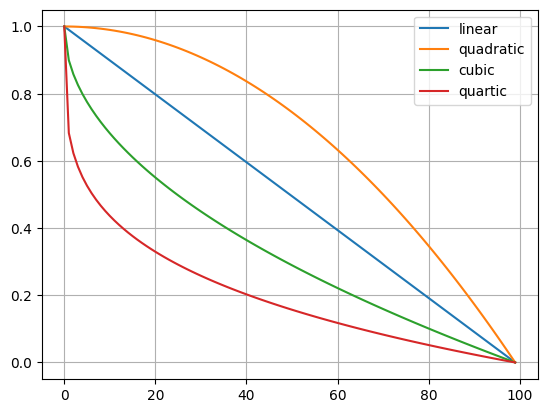

In [32]:
import numpy as np  
import matplotlib.pyplot as plt  
linear_weights = np.linspace(0, 1, 100)  
linear_weights1 = np.linspace(1, 0, 100)  

# 计算二次插值权重  
quadratic_weights2 = 1 - np.power(linear_weights, 2)  
quadratic_weights3 = 1 - np.power(linear_weights, 0.5)  
quadratic_weights4 = 1 - np.power(linear_weights, 0.25)  

plt.plot(linear_weights1, label='linear')  
plt.plot(quadratic_weights2, label='quadratic')  
plt.plot(quadratic_weights3, label='cubic')  
plt.plot(quadratic_weights4, label='quartic')  
plt.legend()  
plt.grid()

In [37]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
def moving_average(data, window_size):  
    """计算滑动平均"""  
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')  
moving_average(a, 5)

array([3., 4., 5., 6., 7., 8.])

In [39]:
array1 = np.array([1, 2, 3])  
array2 = np.array([4, 5, 6])  

# 方法一：使用 np.concatenate  
combined_array = np.concatenate((array1, array2))  
print(combined_array)  
list(array1)+list(array2)   # 也可以使用 list 进行拼接  

[1 2 3 4 5 6]


[1, 2, 3, 4, 5, 6]

In [40]:
2**0.5*290/10000

0.04101219330881976